### Load base model (names set as *_nonlinear.pth)

In [46]:
from ptlpinns.models import model, training, load, transfer
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

name = "overdamped_nonlinear"
base_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}/"
base_name = f"model_{name}.pth"
base_model, training_log = model.load_model(base_path, base_name)

11 True False False [128, 128, 256]


### Initialize transfer learning model

In [47]:
transfer_model = model.transfer_model(training_log, base_model)

### Transfer learning parameters

In [48]:
w_transfer = [1]
zeta_transfer = [30]
q = 3
N = 512
t_span = (0, 15)
t_eval = np.linspace(t_span[0], t_span[1], N)
ic = [1, 0]
initial_condition_functions = [load.initial_condition(y1_0=ic[0], y2_0=ic[1])]
epsilon = 5
equation_functions = [equations.equation_oscillator(w_0=w_transfer[0], epsilon=epsilon, zeta=zeta_transfer[0])]
forcing_functions = [forcing.zeroes_2D(False)]

In [49]:
ode = equations.ode_oscillator_1D(w_0=w_transfer[0], zeta=zeta_transfer[0], forcing_1D = lambda t: np.zeros_like(t), q=q, epsilon=epsilon)
numerical_solution = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic)

### Transfer learning

In [50]:
optimizer = torch.optim.Adam(model.head_parameters(transfer_model), lr=1e-2)
num_iter = 30000
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.95)

In [51]:
transfer.compute_transfer_learning(transfer_model, optimizer, num_iter,
                        equation_functions, initial_condition_functions, forcing_functions,
                        N=N, t_span=t_span, numerical_solution=numerical_solution, every=500)

[iteration] 500 | total 7.834e-03 | ode 3.487e-03 | ic 4.347e-03 | MAE 3.038e-01 | time 18.42
[iteration] 1000 | total 1.290e-02 | ode 8.562e-03 | ic 4.343e-03 | MAE 2.610e-01 | time 35.03
[iteration] 1500 | total 5.935e-03 | ode 1.532e-03 | ic 4.403e-03 | MAE 2.270e-01 | time 51.34
[iteration] 2000 | total 5.675e-03 | ode 1.271e-03 | ic 4.405e-03 | MAE 2.015e-01 | time 67.67
[iteration] 2500 | total 1.564e-02 | ode 1.131e-02 | ic 4.328e-03 | MAE 1.839e-01 | time 83.73
[iteration] 3000 | total 9.001e-03 | ode 4.569e-03 | ic 4.432e-03 | MAE 1.667e-01 | time 99.40
[iteration] 3500 | total 1.203e-02 | ode 7.533e-03 | ic 4.499e-03 | MAE 1.501e-01 | time 115.10
[iteration] 4000 | total 5.268e-03 | ode 8.885e-04 | ic 4.380e-03 | MAE 1.415e-01 | time 129.27
[iteration] 4500 | total 5.062e-03 | ode 6.906e-04 | ic 4.372e-03 | MAE 1.313e-01 | time 146.05
[iteration] 5000 | total 1.584e-01 | ode 1.540e-01 | ic 4.370e-03 | MAE 1.253e-01 | time 163.86
[iteration] 5500 | total 1.448e-02 | ode 9.964e

KeyboardInterrupt: 

### Plotting the results

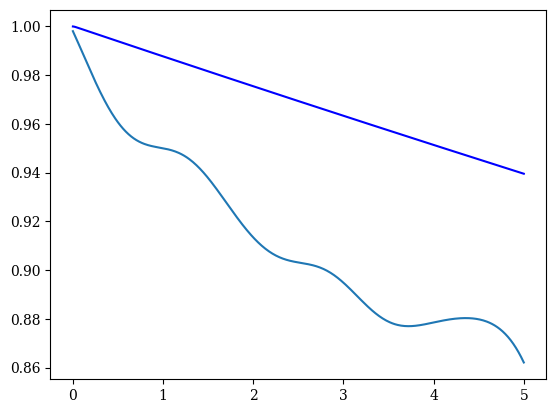

In [ ]:
plt.plot(t_eval, numerical_solution[0, :], label='Numerical Solution', color='blue')
plt.plot(t_eval, transfer_model(training.generate_eval_tensor(N, t_span, False))[0].squeeze()[:, 0].detach().numpy())